## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [11]:
%%R

library(tidycensus)

# Load available variables for the 2021 ACS 5-year dataset
vars_2021 <- load_variables(2021, "acs5", cache = TRUE)

# Filter variables for table B12503
b12503_vars <- vars_2021[grep("^B12503", vars_2021$name), ]
print(b12503_vars)


# A tibble: 11 × 4
   name       label                                            concept geography
   <chr>      <chr>                                            <chr>   <chr>    
 1 B12503_001 Estimate!!Total:                                 DIVORC… state    
 2 B12503_002 Estimate!!Total:!!Male:                          DIVORC… state    
 3 B12503_003 Estimate!!Total:!!Male:!!Never married           DIVORC… state    
 4 B12503_004 Estimate!!Total:!!Male:!!Ever married:           DIVORC… state    
 5 B12503_005 Estimate!!Total:!!Male:!!Ever married:!!Divorce… DIVORC… state    
 6 B12503_006 Estimate!!Total:!!Male:!!Ever married:!!Not div… DIVORC… state    
 7 B12503_007 Estimate!!Total:!!Female:                        DIVORC… state    
 8 B12503_008 Estimate!!Total:!!Female:!!Never married         DIVORC… state    
 9 B12503_009 Estimate!!Total:!!Female:!!Ever married:         DIVORC… state    
10 B12503_010 Estimate!!Total:!!Female:!!Ever married:!!Divor… DIVORC… state    
11 B12503

In [18]:
%%R
library(tidycensus)

# Query divorce data for the state of New York
ny_state_divorce_data <- get_acs(
  geography = "state",       # Fetch data at the state level
  state = "NY",              # State of New York
  variables = c(
    total_population = "B12503_001",  # Total population 15 years and over
    divorced_men = "B12503_005",      # Male: Divorced in the last year
    divorced_women = "B12503_010"     # Female: Divorced in the last year
  ),
  year = 2021,
  survey = "acs5",           # ACS 5-year data
  geometry = FALSE           # No geographic shapes included
)

# View the results
ny_state_divorce_data


# A tibble: 3 × 5
  GEOID NAME     variable         estimate   moe
  <chr> <chr>    <chr>               <dbl> <dbl>
1 36    New York total_population 16621895   695
2 36    New York divorced_men        43348  1821
3 36    New York divorced_women      50310  1499


Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'


In [17]:
%%R
library(tidycensus)

all_states_divorce_data <- get_acs(
  geography = "state",       # Fetch data at the state level
  variables = c(
    total_population = "B12503_001",  # Total population 15 years and over
    divorced_men = "B12503_005",      # Male: Divorced in the last year
    divorced_women = "B12503_010"     # Female: Divorced in the last year
  ),
  year = 2021,
  survey = "acs5",           # ACS 5-year data
  geometry = FALSE           # No geographic shapes included
)

all_states_divorce_data


# A tibble: 156 × 5
   GEOID NAME     variable         estimate   moe
   <chr> <chr>    <chr>               <dbl> <dbl>
 1 01    Alabama  total_population  4070435   820
 2 01    Alabama  divorced_men        19569  1131
 3 01    Alabama  divorced_women      20418  1195
 4 02    Alaska   total_population   582243   301
 5 02    Alaska   divorced_men         2450   399
 6 02    Alaska   divorced_women       2430   448
 7 04    Arizona  total_population  5746333   404
 8 04    Arizona  divorced_men        20572  1214
 9 04    Arizona  divorced_women      22185  1512
10 05    Arkansas total_population  2422833   669
# ℹ 146 more rows
# ℹ Use `print(n = ...)` to see more rows


Getting data from the 2017-2021 5-year ACS


In [25]:

%%R

library(tidycensus)

us_divorce_data <- get_acs(
  geography = "state",       # Fetch data at the state level
  variables = c(
    total_population = "B12503_001",  # Total population 15 years and over
    divorced_men = "B12503_005",      # Male: Divorced in the last year
    divorced_women = "B12503_010"     # Female: Divorced in the last year
  ),
  year = 2021,
  survey = "acs5",           # ACS 5-year data
  geometry = FALSE           # No geographic shapes included
)

us_divorce_data


# A tibble: 156 × 5
   GEOID NAME     variable         estimate   moe
   <chr> <chr>    <chr>               <dbl> <dbl>
 1 01    Alabama  total_population  4070435   820
 2 01    Alabama  divorced_men        19569  1131
 3 01    Alabama  divorced_women      20418  1195
 4 02    Alaska   total_population   582243   301
 5 02    Alaska   divorced_men         2450   399
 6 02    Alaska   divorced_women       2430   448
 7 04    Arizona  total_population  5746333   404
 8 04    Arizona  divorced_men        20572  1214
 9 04    Arizona  divorced_women      22185  1512
10 05    Arkansas total_population  2422833   669
# ℹ 146 more rows
# ℹ Use `print(n = ...)` to see more rows


Getting data from the 2017-2021 5-year ACS


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [26]:
%%R 

us_divorce_data <- us_divorce_data %>% 
  pivot_wider(
    names_from = variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )  # Pivot from long to wide format

us_divorce_data


# A tibble: 52 × 8
   GEOID NAME                 total_population_estimate divorced_men_estimate
   <chr> <chr>                                    <dbl>                 <dbl>
 1 01    Alabama                                4070435                 19569
 2 02    Alaska                                  582243                  2450
 3 04    Arizona                                5746333                 20572
 4 05    Arkansas                               2422833                 12310
 5 06    California                            32012544                 94644
 6 08    Colorado                               4681011                 17433
 7 09    Connecticut                            3002297                  8714
 8 10    Delaware                                810385                  2624
 9 11    District of Columbia                    573678                  1133
10 12    Florida                               17820786                 66750
# ℹ 42 more rows
# ℹ 4 more variables: divorc

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [28]:
%%R 

# Clean and transform the dataset
us_divorce_data <- us_divorce_data %>%
  select(GEOID, NAME, total_population_estimate, divorced_men_estimate, divorced_women_estimate) %>%  # Remove MOE columns
  mutate(
    total_divorced = divorced_men_estimate + divorced_women_estimate,   # Sum of divorced men and women
    divorce_rate = (total_divorced / total_population_estimate) * 100   # Divorce percentage
  )

# View the cleaned dataset
us_divorce_data


# A tibble: 52 × 7
   GEOID NAME                 total_population_estimate divorced_men_estimate
   <chr> <chr>                                    <dbl>                 <dbl>
 1 01    Alabama                                4070435                 19569
 2 02    Alaska                                  582243                  2450
 3 04    Arizona                                5746333                 20572
 4 05    Arkansas                               2422833                 12310
 5 06    California                            32012544                 94644
 6 08    Colorado                               4681011                 17433
 7 09    Connecticut                            3002297                  8714
 8 10    Delaware                                810385                  2624
 9 11    District of Columbia                    573678                  1133
10 12    Florida                               17820786                 66750
# ℹ 42 more rows
# ℹ 3 more variables: divorc

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

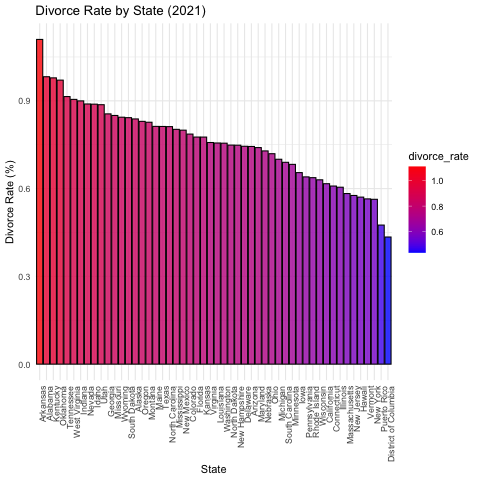

In [33]:
%%R

library(ggplot2)
options(repr.plot.width = 12, repr.plot.height = 6)  # Set wider plot dimensions

# Create a bar chart ranking states by divorce rate
ggplot(us_divorce_data, aes(x = reorder(NAME, -divorce_rate), y = divorce_rate, fill = divorce_rate)) +
  geom_bar(stat = "identity", color = "black", alpha = 0.8) +
  labs(
    title = "Divorce Rate by State (2021)",
    x = "State",
    y = "Divorce Rate (%)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  scale_fill_gradient(low = "blue", high = "red")  # Color gradient for emphasis


In [38]:
%%R

#Confirming that Arkansas has the highest divorce rate?

us_divorce_data %>%
  arrange(desc(divorce_rate)) %>%
  select(NAME, divorce_rate) %>%
  head(5)


# A tibble: 5 × 2
  NAME      divorce_rate
  <chr>            <dbl>
1 Arkansas         1.11 
2 Alabama          0.982
3 Kentucky         0.979
4 Oklahoma         0.971
5 Tennessee        0.915


### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

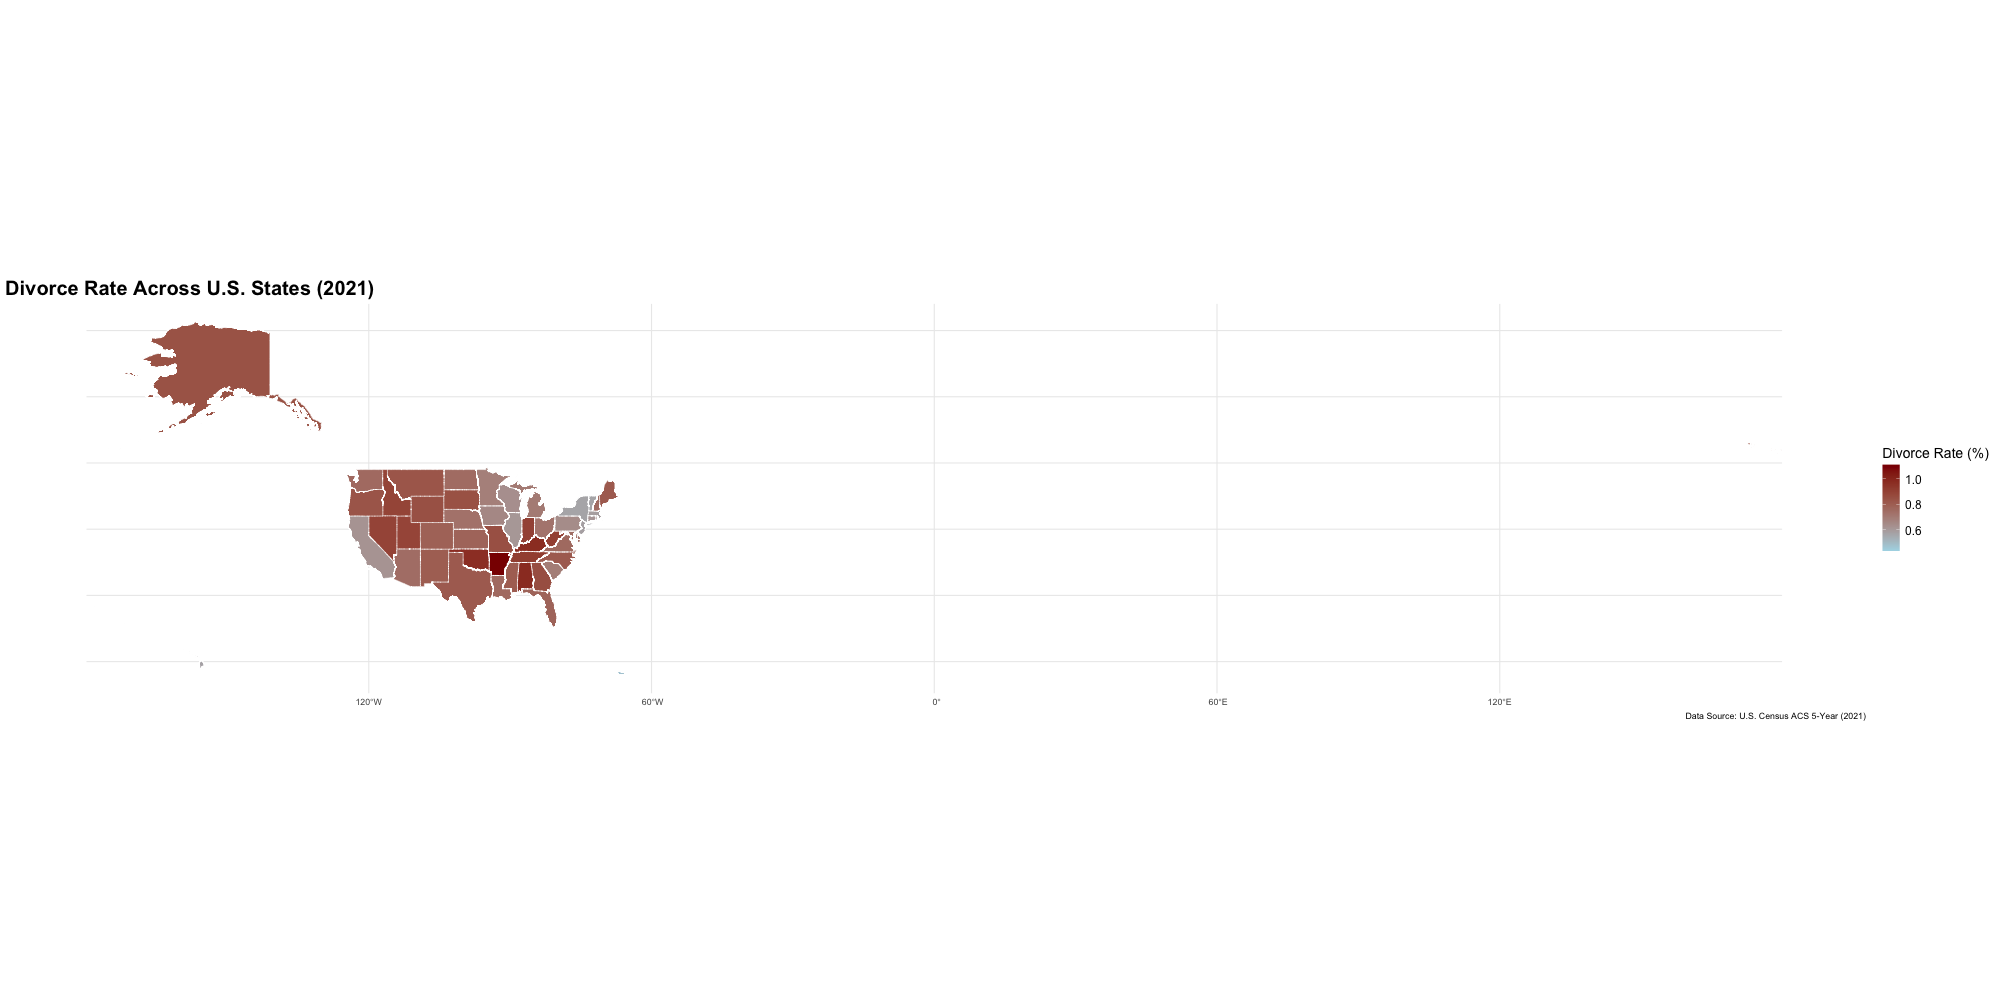

In [50]:
%%R -w 2000 -h 1000

library(tidycensus)
library(tidyverse)
library(sf)

# Set plot size for Jupyter Notebook
options(repr.plot.width = 16, repr.plot.height = 10)  # Increase size

# Create a larger map with distinct colors
ggplot(us_map_data) +
  geom_sf(aes(fill = divorce_rate), color = "white", size = 0.2) +  # States outlined in white
  scale_fill_gradient(
    low = "lightblue",  # Low divorce rate
    high = "darkred",   # High divorce rate
    name = "Divorce Rate (%)"
  ) +
  labs(
    title = "Divorce Rate Across U.S. States (2021)",
    caption = "Data Source: U.S. Census ACS 5-Year (2021)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold"),  # Larger title
    legend.title = element_text(size = 14),              # Larger legend title
    legend.text = element_text(size = 12)                # Larger legend text
  )
